# Introduction

Airlines have made headlines in recent months for ‘bumping’ passengers from their flights. Passenger airlines (and many other industries, including hospitality) sell more seats than they have available, with the expectation that a percentage of their customers will not show up. This allows the company to ensure that they are always running at full capacity. While this makes economic sense, it is a delicate balance - if they operate under capacity, they are losing revenue; if they book too many customers, they will need to cancel reservations. This can lead to additional lost revenue in the form of vouchers, as well as a potential public relations fallout if handled improperly.

The goal of this project is to run a Monte Carlo simulation to predict the optimal number of passengers to book for a given flight.

# Data

Data will be sourced from official statistics where available. In the event that I am unable to procure concrete numbers during my research, I will create my own based on the information available.

# Preliminary Exploration

In order to devise a formula for estimation, we will first need to define several variables.

#### Number of Seats

According to the [MIT Airline Data Project](http://web.mit.edu/airlinedata/www/Aircraft&Related.html), there was an average of 178 available seats per aircraft on US domestic carriers in 2017.

Thus, we will define the variable for number of seats as `num_seats` $= 178$.

#### Probability of Passenger Catching Flight

It's impossible to find an exact number for the number of no-shows on US flights, since these figures are not made public by the airlines. [Some](https://www.quora.com/What-is-the-no-show-rate-for-airlines/answer/David-Watson-329) sources suggest between 1-1.5%, while [others](https://www.linkedin.com/pulse/united-airlines-how-overbook-flight-mathematical-version-dror-guzman) put it much higher, in the range of 5-10%. I will use 5%, as I believe it to be closer to the true probability.

Thus, we will assign the probability that a passenger shows up to the flight to be `passenger_show` $= 0.95$.

#### Ticket Cost

According to the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/AIRFARES/), the average price of a ticket for a domestic flight in the US in 2017 was \\$$347.73$. For the sake of mathematical simplicity, we will round this number up to a flat \\$$348$.

Thus, we will define the variable for the cost of a ticket as `ticket_price` $= 348$. 

#### Voucher Value

The federal government regulates the market, and has granted consumers specific rights to protect them from harmful business practices. In most scenarios when a passenger is bumped, they are entitled to some form of compensation from the airline, be it cash or a voucher to use on a future flight. As outlined by the [BTS](https://www.transportation.gov/individuals/aviation-consumer-protection/bumping-oversales), passengers bumped from a domestic flight are typically entitled to (a minimum of) 200\% of their ticket cost. 

Thus, we will define the variable for voucher as `voucher` $= 2 \ \times$ `ticket_price`.

# Building the Model

#### Number of Passengers

Our first step to building the model is to determine the number of passengers that show up and make (i.e. catch) their flight.

In [2]:
import numpy as np

def num_of_passengers(passenger_show, num_tickets):
    
    '''
    This function will simulate the number of passengers who have a reservation and will actually
    make it on board, based on the probability and number of tickets sold given above.
    '''
    
    # Generate n = num_seats random numbers from the uniform distribution
    random_passengers = np.random.uniform(size=num_tickets)
    num_passengers = sum(i < passenger_show for i in random_passengers)
    
    return(num_passengers)

#### Revenue Earned

Once we know the number of customers that purchased a ticket and made their flight, we can calculate the revenue earned from ticket sales.  
If the number of passengers was less than or equal to the number of seats available on the plane, then the revenue is simply the product of the number of tickets sold and the price of each ticket.  
If too many passengers showed, we would need to bump and compensate all those beyond seating capacity. This number, multiplied by the value of each voucher, would be subtracted from revenue earned from ticket sales.

In [3]:
def calculate_revenue(passenger_show, num_seats, num_tickets, ticket_price, voucher):
    
    '''
    This function will calculate the revenue earned on a flight, given the number of seats, the number of tickets sold,
    the ticket price, the number of bumped passengers, and voucher amount.
    '''
    
    num_passengers = num_of_passengers(passenger_show, num_tickets)
    
    if num_passengers > num_seats:
        excess_tickets = num_passengers - num_seats
        revenue = (num_seats * ticket_price) - (excess_tickets * voucher)
    else:
        revenue = num_passengers * ticket_price
    return(revenue)

#### Flight Simulator!

With the above two functions, we'll be able to calculate the number of passengers, and the revenue earned for each flight.  
We'll now create a function to simulate a large number of flights, in order to give us a good approximation of the optimal number of excess tickets to sell.

In [13]:
import pandas as pd

def flight_simulator(passenger_show, num_seats, num_tickets, ticket_price, voucher):
    
    '''
    This function run the two previous ones a (user-defined) number of times for each extra ticket sold beyond capacity. 
    '''
    
    cols = ['Num_Extra_Tickets', 'Flight_number', 'Revenue']
    revdf = pd.DataFrame(index = range(200000), columns = cols)
    
    index = 0
    for i in range(0, 20):
        num_tickets = num_seats + i
        for j in range(0, 10000):
            rev = calculate_revenue(passenger_show, num_seats, num_tickets, ticket_price, voucher)
            revdf.iloc[index, ] = [i, j, rev]
            index += 1
    revdf.to_csv("results.csv")    

# Results

The simulation was performed using anywhere from 0 to 19 extra tickets, with 10,000 runs for each case.  
I used the following variables:

- `num_seats` $= 178$  
- `passenger_show` $= 0.95$  
- `ticket_price` $= 348$  
- `voucher` $= 2 \ \times $ `ticket_price`

Below is a boxplot with the mean revenue earned based on the number of extra tickets sold.

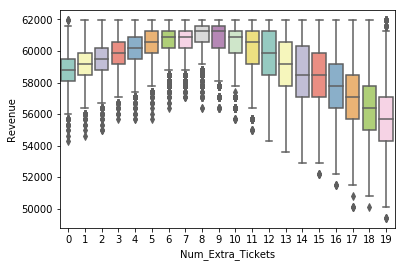

In [26]:
import seaborn as sns

df = pd.read_csv('results.csv', usecols = ['Num_Extra_Tickets', 'Revenue'])
df.groupby("Num_Extra_Tickets").aggregate("mean")

bp = sns.boxplot(x = "Num_Extra_Tickets", y = "Revenue", data = df, palette="Set3")

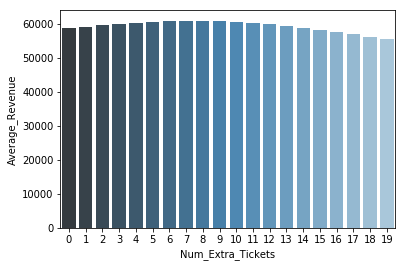

In [73]:
df = pd.read_csv('results.csv', usecols = ['Num_Extra_Tickets', 'Revenue'])
gdf = df.groupby("Num_Extra_Tickets", as_index=False).agg("mean")
gdf = gdf.rename(columns = {"Revenue": "Average_Revenue"})
bc = sns.barplot(x = "Num_Extra_Tickets", y = "Average_Revenue", palette="Blues_d", data = gdf)

In [74]:
gdf

,Num_Extra_Tickets,Average_Revenue
0,0,58857.5184
1,1,59161.1136
2,2,59498.1168
3,3,59819.5296
4,4,60108.2304
5,5,60429.6780
6,6,60657.5136
7,7,60811.1556
8,8,60858.4140
9,9,60784.7076


# Final Thoughts

From the above charts and plots, we see that the airline (usually) earned the most revenue when they sold between six and eight tickets.  
What's nice about the above functions, is that we could tinker with our assumptions and variables, which might hint which variables are most affecting revenue.

I have some thoughts on expanding this program if someone would want to make it more rigorous for professional use.  
The aircraft could be further divided based on cabin offerings (e.g. first class, business, economy). We would need to assign weights to each, since, for example, a bumped passenger with a first class ticket will be entitled to higher compensation, which detracts substantially more revenue.  
Another idea would be to take into account the effect of bad PR. If an airline bumps passengers too often, consumers would be hesitant to fly with them in the future. If we could somehow quantify a value for a company's reputation, it could be built into the model.